In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
import model_zoo

import data_freiburg_numpy_to_hdf5

In [832]:
# Debug session with 4 training and 2 validation on total model
# The model.train() is now in the right place
# Still have to check the data augmentation

# ======================================================================
debug_dir = "/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/CNN-segmentation/logdir/unet3d_da_0.0nchannels1_rrun_small_image_set/results/visualization/"

In [836]:
list_files_train = os.listdir(debug_dir + 'training/')
image_number_train = 0
list_files_train

['step_0_pred_image_0.npy',
 'step_0_true_image_0.npy',
 'step_0_input_image_0.npy',
 'step_400_pred_image_0.npy',
 'step_400_true_image_0.npy',
 'step_400_input_image_0.npy']

In [837]:
image_filter_train = list(filter(lambda x: f'_image_{image_number_train}' in x, list_files_train))
image_filter_train

['step_0_pred_image_0.npy',
 'step_0_true_image_0.npy',
 'step_0_input_image_0.npy',
 'step_400_pred_image_0.npy',
 'step_400_true_image_0.npy',
 'step_400_input_image_0.npy']

In [838]:
step = 400
pred_train = np.load(os.path.join(debug_dir,'training', list(filter(lambda x: f'_{step}' in x, image_filter_train))[0]))
gt_train = np.load(os.path.join(debug_dir,'training', list(filter(lambda x: f'_{step}' in x, image_filter_train))[1]))
input_train = np.load(os.path.join(debug_dir,'training', list(filter(lambda x: f'_{step}' in x, image_filter_train))[2]))
np.where(gt_train ==1), np.where(pred_train ==1)


((array([0, 0, 0, ..., 5, 5, 5]),
  array([ 28,  28,  28, ..., 143, 143, 143]),
  array([45, 45, 45, ..., 51, 51, 51]),
  array([ 6,  7,  8, ..., 35, 36, 37])),
 (array([0, 0, 0, ..., 5, 5, 5]),
  array([ 37,  37,  37, ..., 139, 139, 139]),
  array([72, 72, 72, ..., 53, 53, 53]),
  array([6, 7, 8, ..., 7, 8, 9])))

In [839]:
pred_train.shape, gt_train.shape, input_train.shape

((8, 144, 112, 38), (8, 144, 112, 38), (8, 1, 144, 112, 38))

In [840]:
def plot_batches(array, input_image = False):

    if input_image:
        fig, axs = plt.subplots(2, 4, figsize=(10,10))
        for n, ax in enumerate(axs.reshape(-1)):
            ax.imshow(array[n,0,:,:,3])
        plt.show()
    else:
        fig, axs = plt.subplots(2, 4, figsize=(10,10))
        for n, ax in enumerate(axs.reshape(-1)):
            ax.imshow(array[n,:,:,3])
        plt.show()

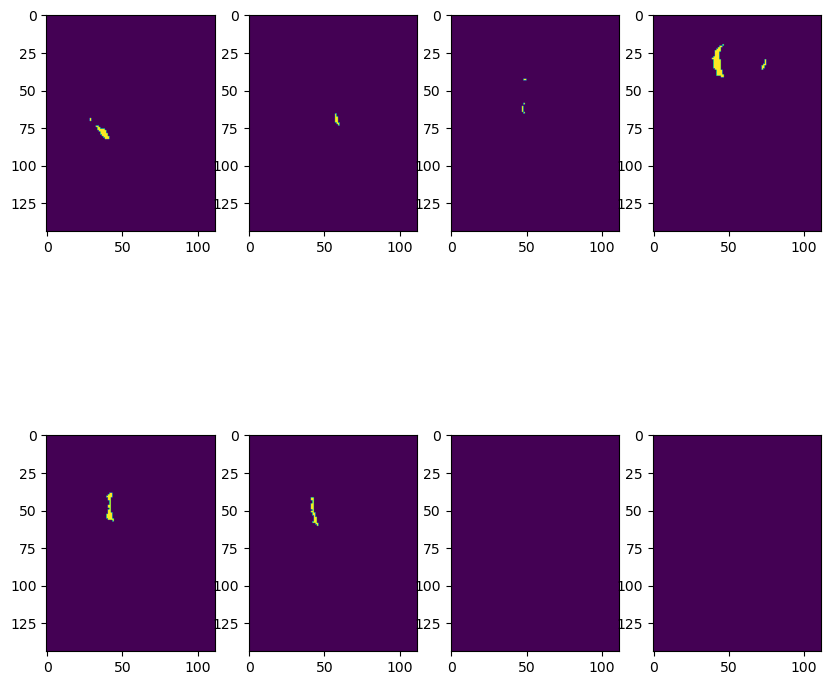

In [841]:
plot_batches(pred_train)

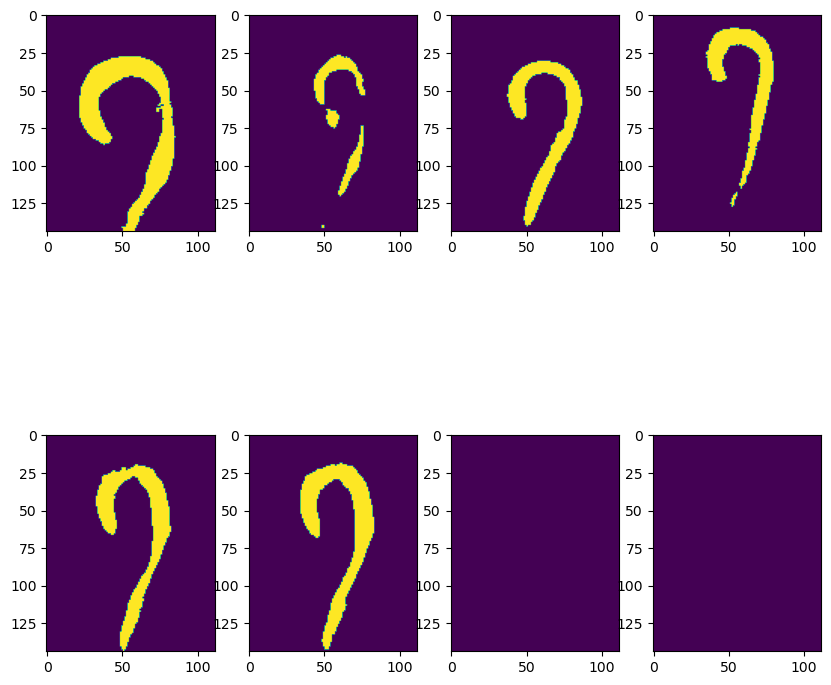

In [842]:
plot_batches(gt_train)

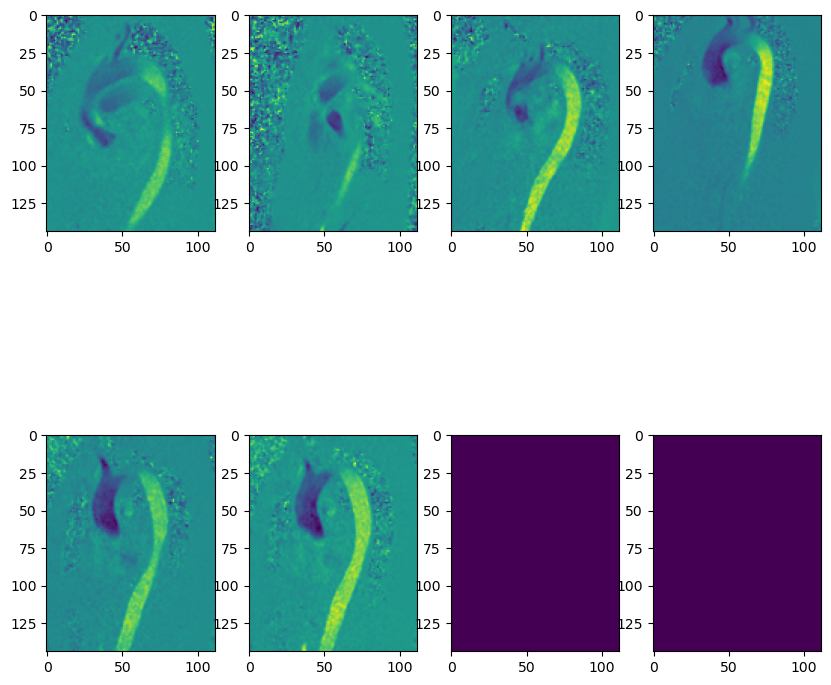

In [843]:
plot_batches(input_train, input_image= True)

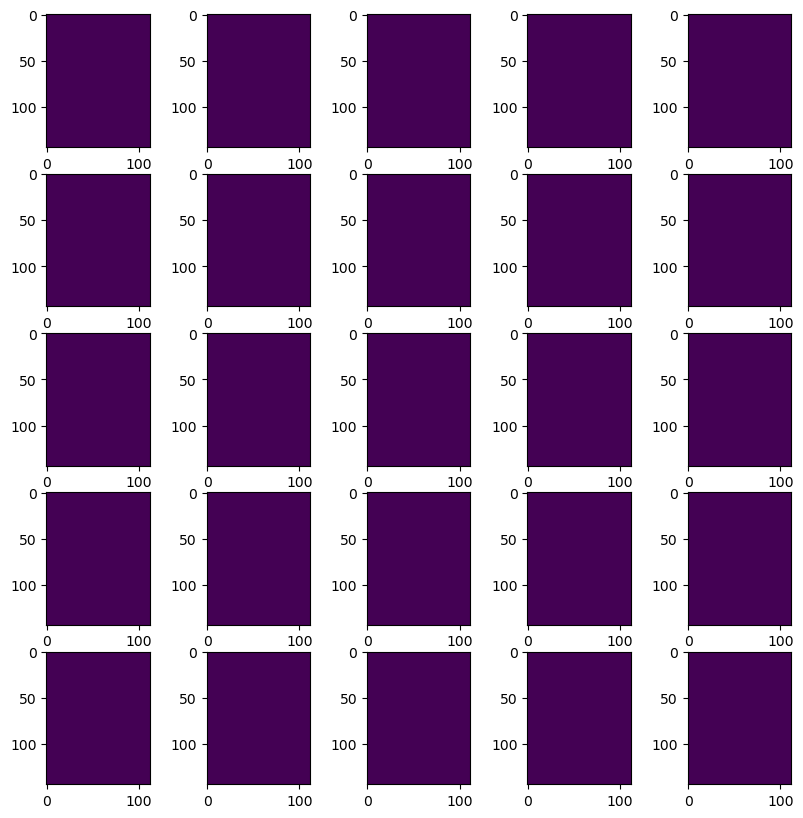

In [606]:
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
batch_image = 1
for i, ax in enumerate(axs.reshape(-1)):
    
    ax.imshow(pred_train[batch_image, :, :, i])


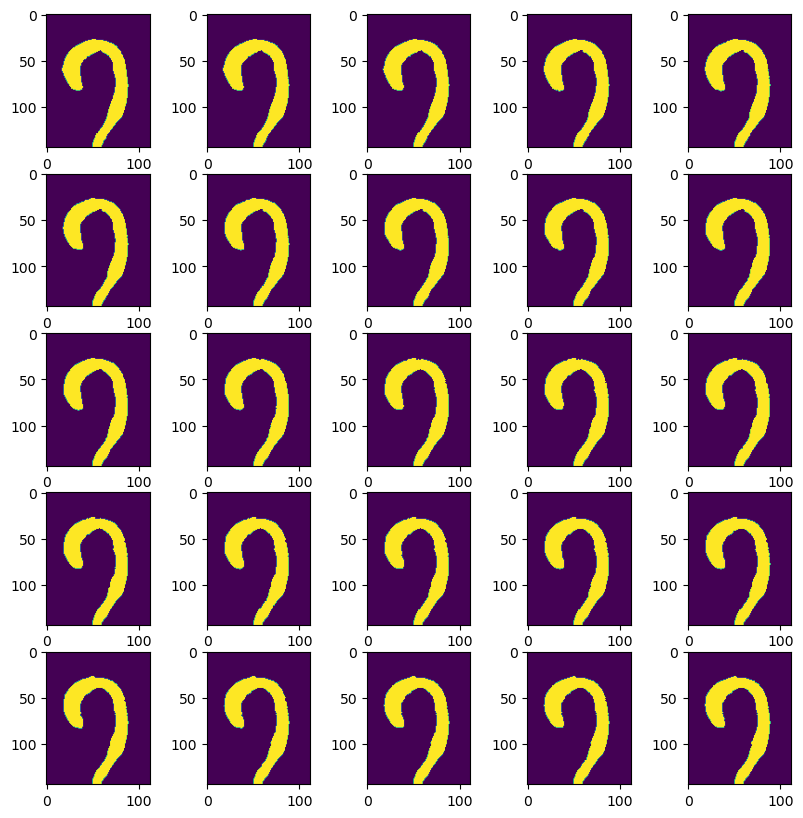

In [607]:
fig, axs = plt.subplots(5, 5, figsize=(10, 10))

for i, ax in enumerate(axs.reshape(-1)):
    
    ax.imshow(gt_train[batch_image, :, :, i])


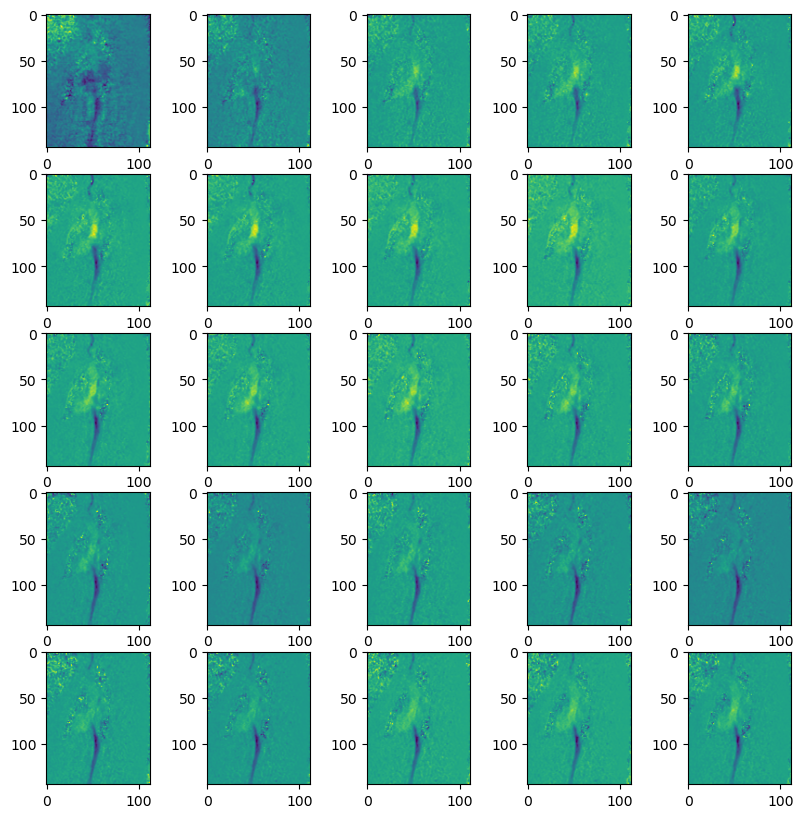

In [608]:
fig, axs = plt.subplots(5, 5, figsize=(10, 10))

for i, ax in enumerate(axs.reshape(-1)):
    
    ax.imshow(input_train[batch_image, 1,:, :, i])


In [433]:
# load saved model
loss = "dice"
out_channels = 2
in_channels = 4
model_path = f'/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/CNN-segmentation/logdir/unet3d_da_0.25nchannels{in_channels}_rclean_03_{loss}'
best_model_path = os.path.join(model_path, list(filter(lambda x: 'best' in x, os.listdir(model_path)))[-1])

model = model_zoo.UNet(in_channels, out_channels)
model.load_state_dict(torch.load(best_model_path, map_location=torch.device('cpu')))
model.eval()

In [437]:
project_data_root = '/usr/bmicnas02/data-biwi-01/jeremy_students/previous_work/nicolas/data/freiburg'
data_vl = data_freiburg_numpy_to_hdf5.load_data(basepath = project_data_root,

                                                        idx_start = 20,
                                                        idx_end = 24,
                                                        train_test='validation')
images_vl = data_vl['images_validation']
labels_vl = data_vl['labels_validation']        

Already preprocessed this configuration. Loading now...


In [536]:
images_vl.shape, labels_vl.shape

((160, 144, 112, 48, 4), (160, 144, 112, 48))

In [535]:
# Data augmentation dimension 
# Set trian inside the loop 

160

In [461]:
batch_size = 8
np.random.seed(0)
inputs = images_vl[np.sort(np.random.randint(len(images_vl), size = batch_size))]
np.random.seed(0)
labels = labels_vl[np.sort(np.random.randint(len(images_vl), size = batch_size))]

inputs = torch.from_numpy(inputs)
# Input (batch_size, channell,x,y,z)
inputs.transpose_(1,4).transpose_(2,4).transpose_(3,4)
labels = torch.from_numpy(labels)

In [463]:
pred = model(inputs)

In [465]:
import torch.nn.functional as F
prediction = F.softmax(pred, dim=1).argmax(dim = 1)

In [467]:
prediction.shape, labels.shape

(torch.Size([8, 144, 112, 48]), torch.Size([8, 144, 112, 48]))

In [485]:
%matplotlib inline
def plot_time(t = 0):
    fig, axs = plt.subplots(4,4);
    img = 0
    for i, ax in enumerate(axs.reshape(-1)):
        
        if i%2 == 0:
            ax.imshow(prediction[img,:,:,t].detach().numpy())
            

        else:
            ax.imshow(labels[img,:,:,t].detach().numpy())   
            img = img + 1 
    fig.show()

/tmp/ipykernel_2016/3488933913.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


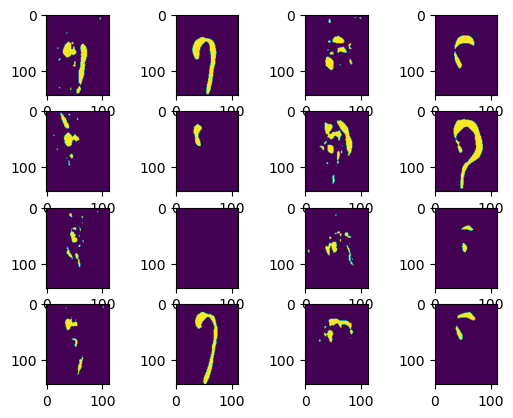

In [486]:
plot_time(0)

/tmp/ipykernel_2016/3488933913.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


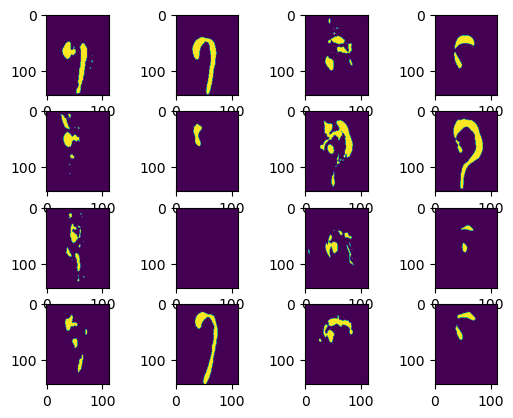

In [487]:
plot_time(1)

/tmp/ipykernel_2016/3488933913.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


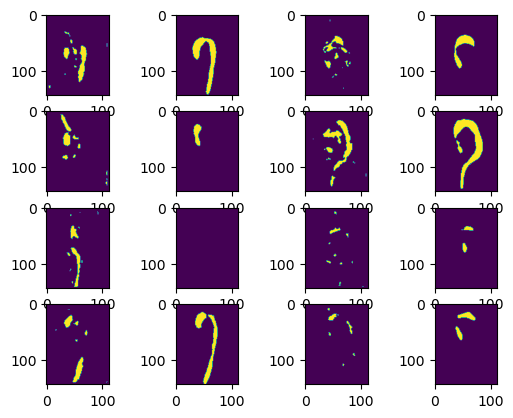

In [488]:
plot_time(20)

In [688]:
results_dir = '/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/CNN-segmentation/logdir/unet3d_da_0.0nchannels4_rdebug_entropy_one_patient/results/visualization/training'
list_files = os.listdir(results_dir)
list_files

['step_0_pred_image_0.npy',
 'step_0_true_image_0.npy',
 'step_0_input_image_0.npy',
 'step_0_pred_image_3.npy',
 'step_0_true_image_3.npy',
 'step_0_input_image_3.npy',
 'step_60_pred_image_0.npy',
 'step_60_true_image_0.npy',
 'step_60_input_image_0.npy',
 'step_60_pred_image_3.npy',
 'step_60_true_image_3.npy',
 'step_60_input_image_3.npy',
 'step_120_pred_image_0.npy',
 'step_120_true_image_0.npy',
 'step_120_input_image_0.npy',
 'step_120_pred_image_3.npy',
 'step_120_true_image_3.npy',
 'step_120_input_image_3.npy',
 'step_180_pred_image_0.npy',
 'step_180_true_image_0.npy',
 'step_180_input_image_0.npy',
 'step_180_pred_image_3.npy',
 'step_180_true_image_3.npy',
 'step_180_input_image_3.npy',
 'step_240_pred_image_0.npy',
 'step_240_true_image_0.npy',
 'step_240_input_image_0.npy',
 'step_240_pred_image_3.npy',
 'step_240_true_image_3.npy',
 'step_240_input_image_3.npy',
 'step_300_pred_image_0.npy',
 'step_300_true_image_0.npy',
 'step_300_input_image_0.npy',
 'step_300_pred_i

In [689]:
image_number = 0
image_filter = list(filter(lambda x: f'_image_{image_number}' in x, list_files))

In [690]:
epoch = 540
pred = np.load(os.path.join(results_dir, list(filter(lambda x: f'step_{epoch}' in x, image_filter))[0]))
gt = np.load(os.path.join(results_dir, list(filter(lambda x: f'step_{epoch}' in x, image_filter))[1]))
np.where(gt ==1), np.where(pred ==1)


((array([0, 0, 0, ..., 7, 7, 7]),
  array([40, 40, 40, ..., 62, 62, 62]),
  array([50, 51, 51, ..., 77, 77, 77]),
  array([17, 16, 17, ..., 28, 29, 30])),
 (array([], dtype=int64),
  array([], dtype=int64),
  array([], dtype=int64),
  array([], dtype=int64)))

In [692]:
pred.shape

(8, 144, 112, 48)

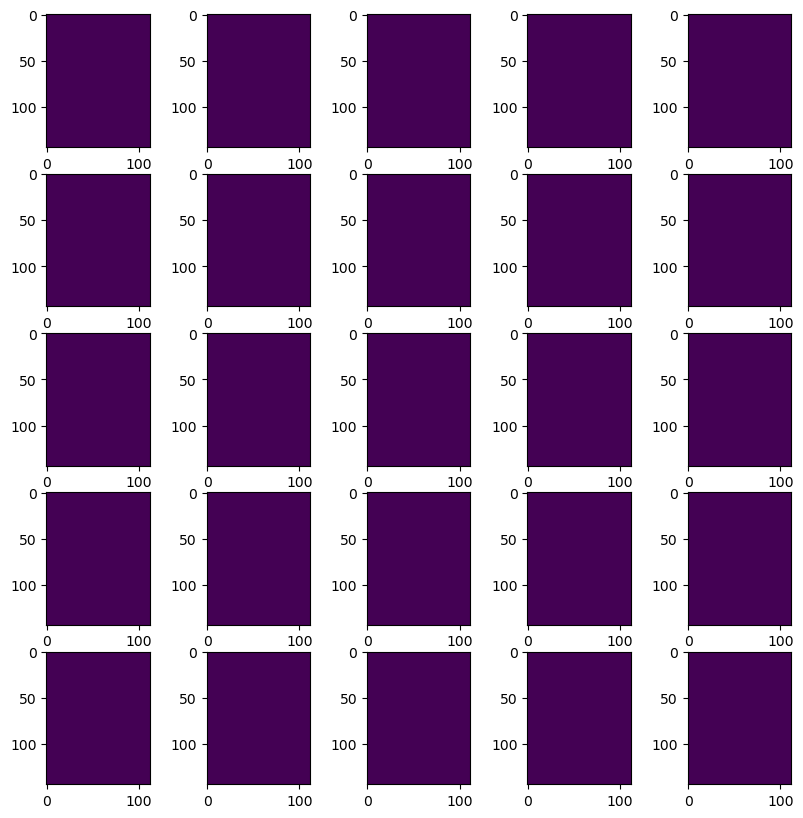

In [698]:
fig, axs = plt.subplots(5, 5, figsize=(10, 10))

for i, ax in enumerate(axs.reshape(-1)):
    
    ax.imshow(pred[7, :, :, i])


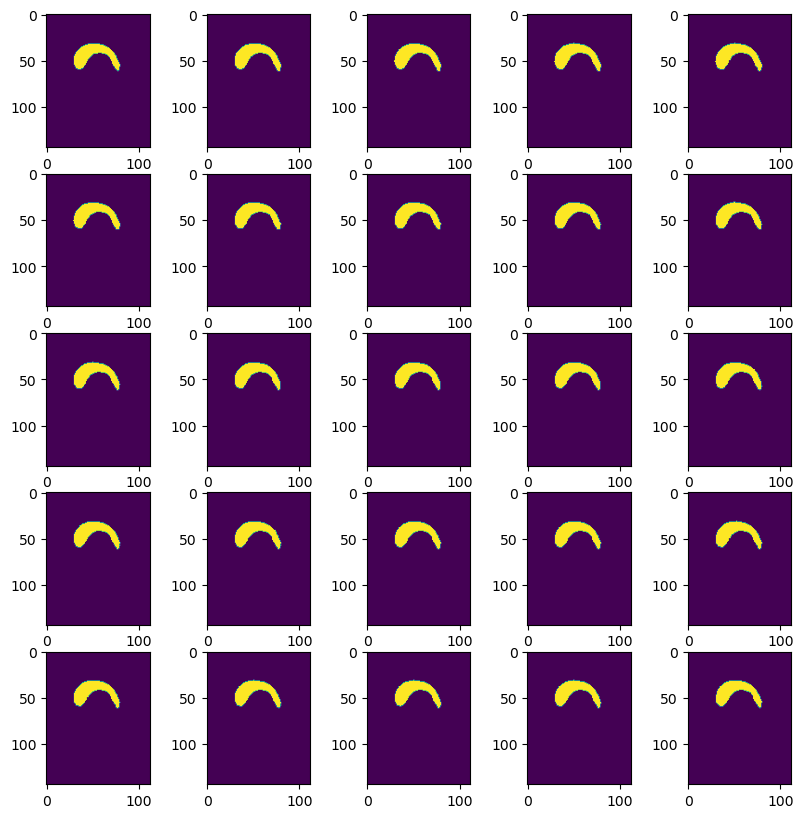

In [697]:
fig, axs = plt.subplots(5, 5, figsize=(10, 10))

for i, ax in enumerate(axs.reshape(-1)):
    
    ax.imshow(gt[7, :, :, i])


(<matplotlib.image.AxesImage at 0x7f6a468cb520>,)

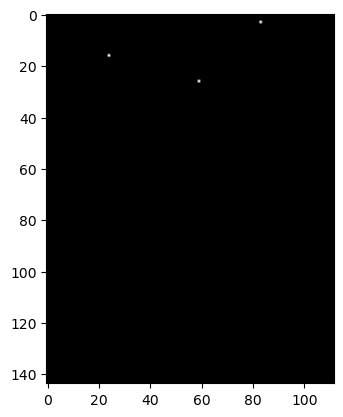

In [62]:

plt.imshow(pred[4, :, :, 10], cmap='gray'), 
#plt.imshow(gt[0, :, :, 0], cmap='gray')

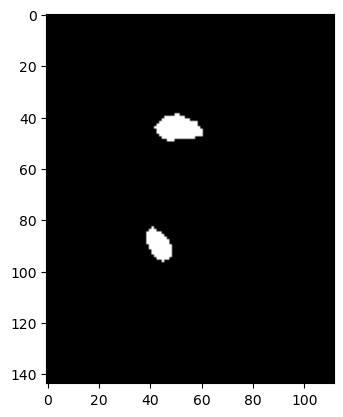

In [489]:
results_dir_debug = '/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/CNN-segmentation/logdir/unet3d_da_0.0nchannels4_rsingle_image_cross_1000_direct_cross_loss/results/visualization/'

In [490]:
list_files_train = os.listdir(results_dir_debug + 'training/')
image_number_train = 0
image_filter_train = list(filter(lambda x: f'_image_{image_number_train}' in x, list_files_train))

In [507]:
step = 600
pred_train = np.load(os.path.join(results_dir_debug,'training', list(filter(lambda x: f'_{step}' in x, list_files_train))[0]))
gt_train = np.load(os.path.join(results_dir_debug,'training', list(filter(lambda x: f'_{step}' in x, list_files_train))[1]))
np.where(gt_train ==1), np.where(pred_train ==1)


((array([0, 0, 0, ..., 0, 0, 0]),
  array([ 28,  28,  28, ..., 143, 143, 143]),
  array([51, 51, 51, ..., 55, 55, 55]),
  array([0, 1, 2, ..., 3, 4, 5])),
 (array([0, 0, 0, ..., 0, 0, 0]),
  array([  5,   5,   5, ..., 141, 141, 141]),
  array([44, 44, 44, ..., 55, 55, 56]),
  array([30, 31, 32, ..., 17, 18,  3])))

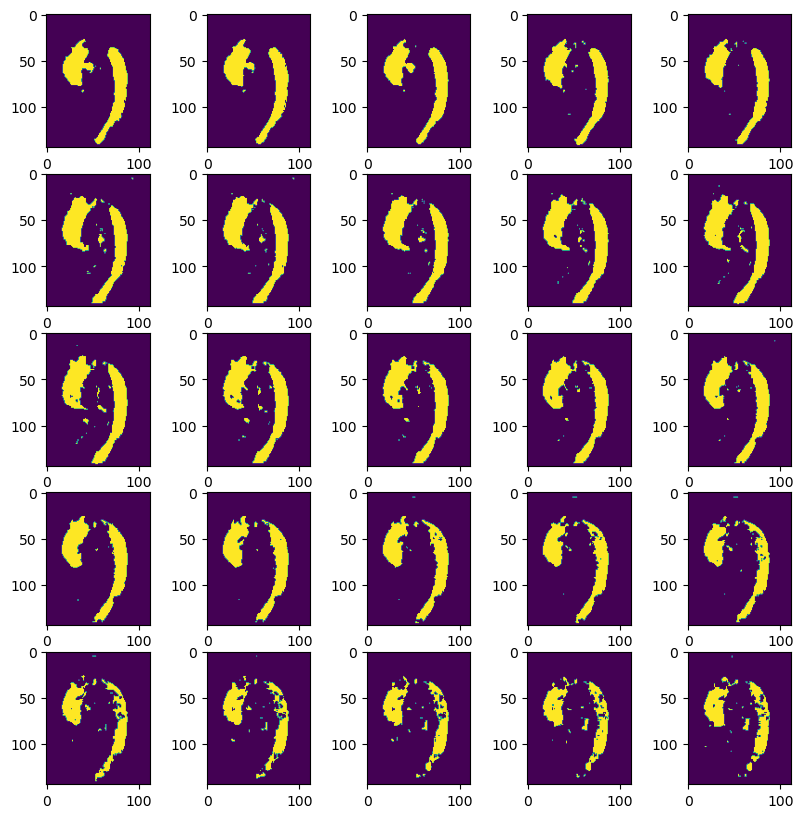

In [508]:
fig, axs = plt.subplots(5, 5, figsize=(10, 10))

for i, ax in enumerate(axs.reshape(-1)):
    
    ax.imshow(pred_train[0, :, :, i])


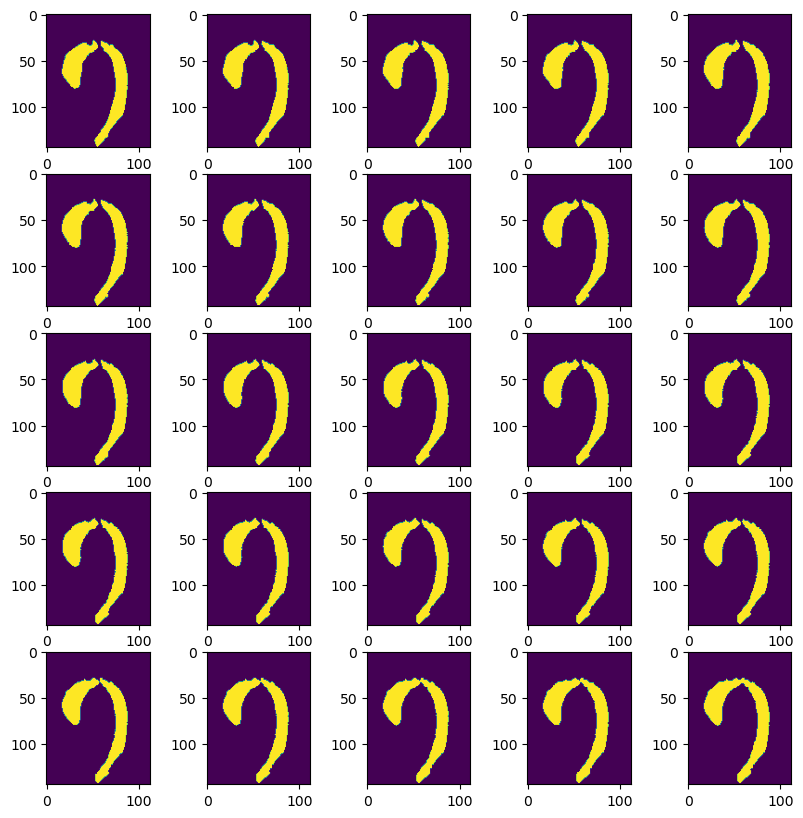

In [494]:
fig, axs = plt.subplots(5, 5, figsize=(10, 10))

for i, ax in enumerate(axs.reshape(-1)):
    
    ax.imshow(gt_train[0, :, :, i])


In [513]:
(gt_train[0,...,15] == gt_train[0,...,40]).all()

False

In [671]:
# Shitty test to check batches 

path = "/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/CNN-segmentation/testing_batches/batch1"

In [672]:
img = np.load(os.path.join(path, 'images.npy'))
seg = np.load(os.path.join(path, 'labels.npy'))

In [673]:
img.shape, seg.shape

((8, 144, 112, 48, 4), (8, 144, 112, 48))

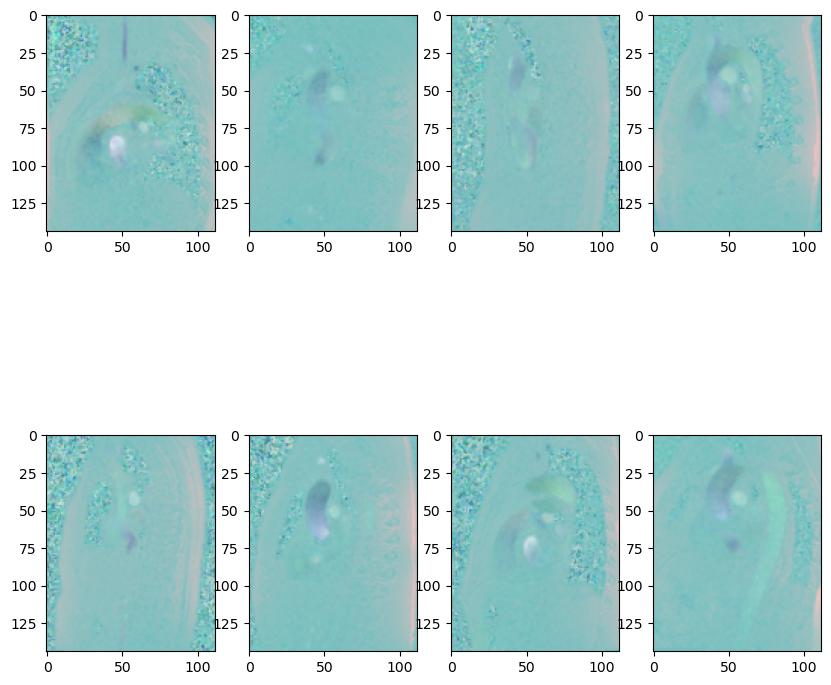

In [674]:
plot_batches(img)

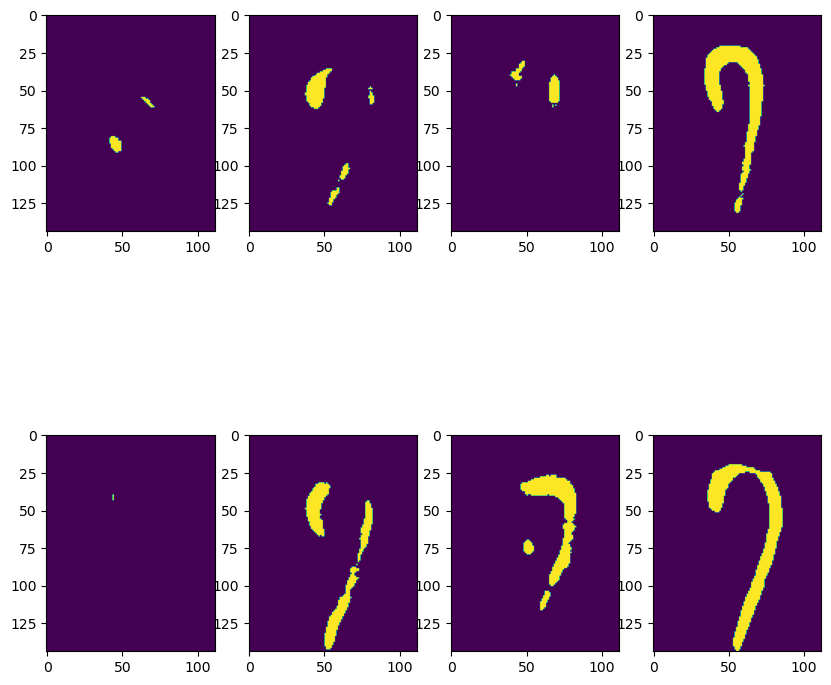

In [675]:
plot_batches(seg)

In [820]:
# Different main debug
path_data_debug_main = "/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/CNN-segmentation/testing_batches/cut_channel_1_debug_01/"

In [821]:
os.listdir(path_data_debug_main)

['images_0.npy',
 'prediction_0.npy',
 'labels_0.npy',
 'images_20.npy',
 'prediction_20.npy',
 'labels_20.npy',
 'images_40.npy',
 'prediction_40.npy',
 'labels_40.npy',
 'images_60.npy',
 'prediction_60.npy',
 'labels_60.npy',
 'images_80.npy',
 'prediction_80.npy',
 'labels_80.npy',
 'images_100.npy',
 'prediction_100.npy',
 'labels_100.npy',
 'images_120.npy',
 'prediction_120.npy',
 'labels_120.npy',
 'images_140.npy',
 'prediction_140.npy',
 'labels_140.npy',
 'images_160.npy',
 'prediction_160.npy',
 'labels_160.npy',
 'images_180.npy',
 'prediction_180.npy',
 'labels_180.npy',
 'images_200.npy',
 'prediction_200.npy',
 'labels_200.npy',
 'images_220.npy',
 'prediction_220.npy',
 'labels_220.npy',
 'images_240.npy',
 'prediction_240.npy',
 'labels_240.npy',
 'images_260.npy',
 'prediction_260.npy',
 'labels_260.npy',
 'images_280.npy',
 'prediction_280.npy',
 'labels_280.npy',
 'images_300.npy',
 'prediction_300.npy',
 'labels_300.npy',
 'images_320.npy',
 'prediction_320.npy',


In [826]:
n = 120
from scipy.special import softmax


img = np.load(os.path.join(path_data_debug_main, f'images_{n}.npy'))

seg = np.load(os.path.join(path_data_debug_main, f'labels_{n}.npy'))

pred = np.load(os.path.join(path_data_debug_main, f'prediction_{n}.npy'))

img.shape, seg.shape, pred.shape

((8, 1, 144, 112, 38), (8, 144, 112, 38), (8, 2, 144, 112, 38))

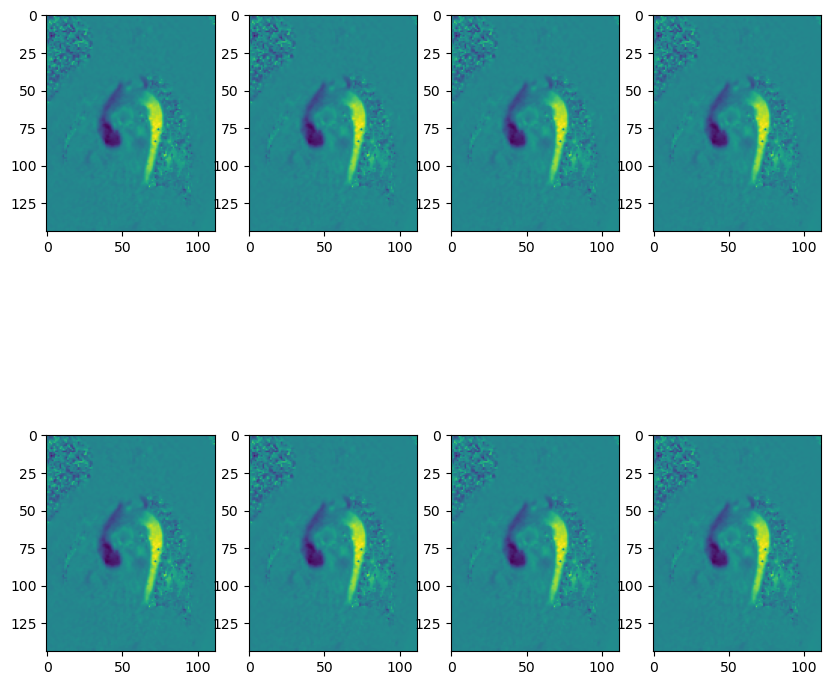

In [827]:
plot_batches(img, input_image= True)

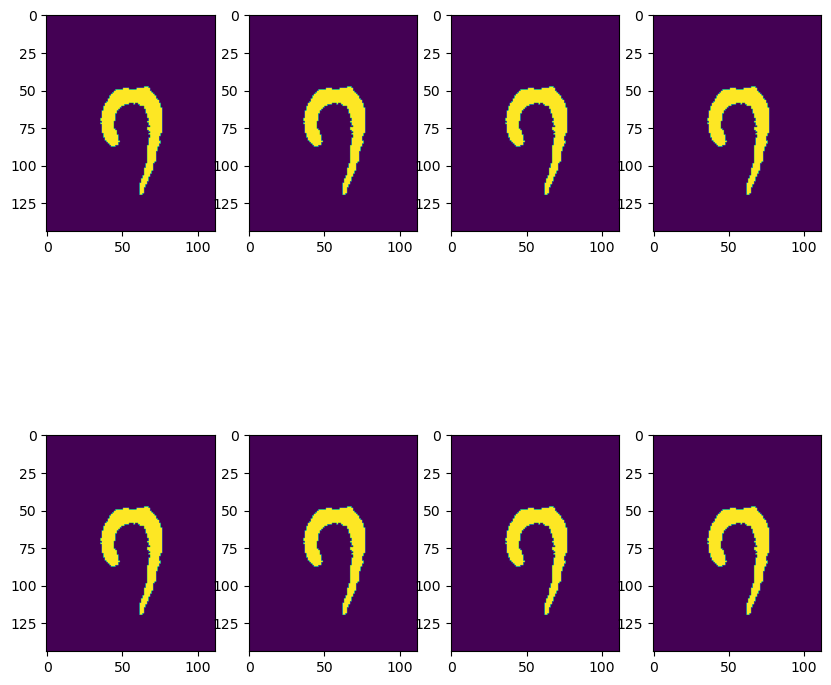

In [828]:
plot_batches(seg)

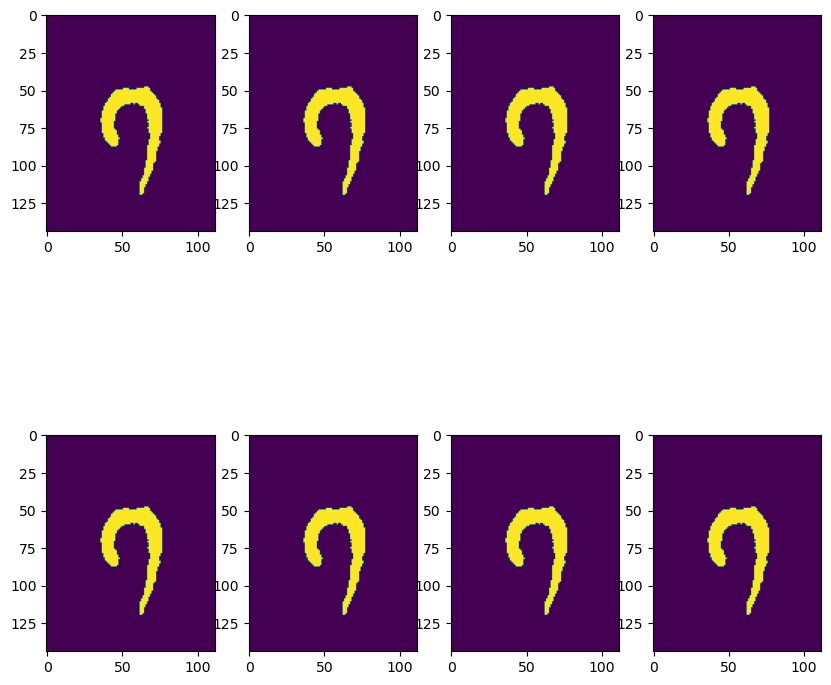

In [829]:
plot_batches(softmax(pred, axis = 1).argmax(axis = 1))

In [774]:
seg.shape, softmax(pred, axis = 1).argmax(axis = 1).shape

((8, 144, 112, 48), (8, 144, 112, 48))

In [775]:
%matplotlib inline
def plot_time_(t = 0):
    fig, axs = plt.subplots(4,4);
    img = 0
    for i, ax in enumerate(axs.reshape(-1)):
        
        if i%2 == 0:
            ax.imshow(softmax(pred, axis = 1).argmax(axis = 1)[img,:,:,t])
            

        else:
            ax.imshow(seg[img,:,:,t])   
            img = img + 1 
    fig.show()

/tmp/ipykernel_2016/2304850047.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


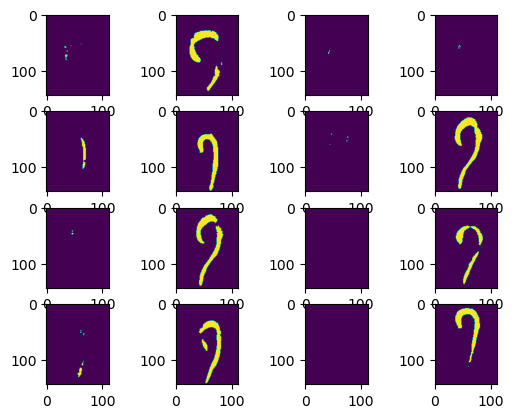

In [776]:
plot_time_(0)

In [818]:
# Check single image ouput
path_single_image = "/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/CNN-segmentation/testing_batches/cut_channel_1_debug_01/"


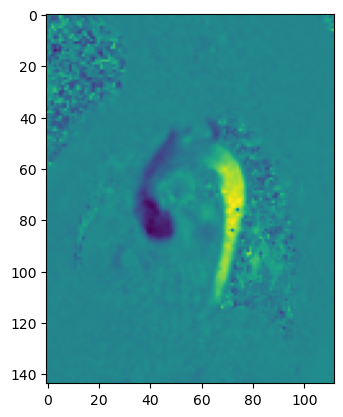

In [817]:
plt.imshow(in_[2, :, :, 1,1])

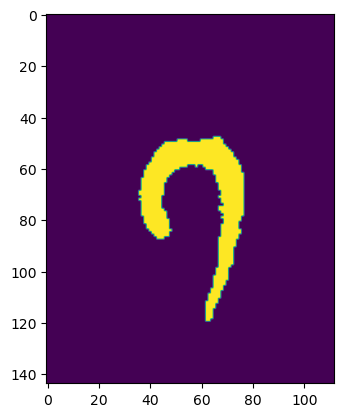

In [816]:
plt.imshow(out_[2, :, :, 1])

In [106]:



path_cut_2 = "/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/CNN-segmentation/logdir/unet3d_da_0.0nchannels4_r_phase_dice_cut_z_2_debug_print_input/"

input_cut = np.load(path_cut_2 + 'inputs_train.npy')

In [108]:

label_cut = np.load(path_cut_2 + 'labels_train.npy')

In [109]:
input_cut.shape
slice_ = 0

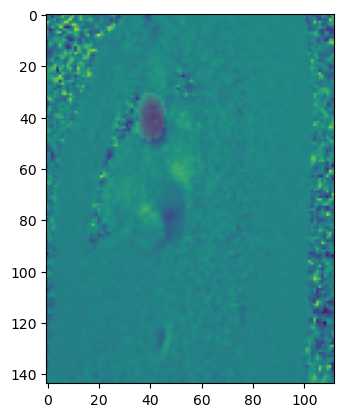

In [170]:
%matplotlib inline
plt.imshow(input_cut[slice_, :,:, 3,1])
plt.imshow(label_cut[slice_, :,:, 3], alpha= 0.1)
slice_ +=1 
plt.show()

In [172]:
project_data_root = '/usr/bmicnas02/data-biwi-01/jeremy_students/previous_work/nicolas/data/freiburg'
data_tr = data_freiburg_numpy_to_hdf5.load_data(basepath = project_data_root,
                                                    idx_start = 0,
                                                    idx_end = 19,
                                                    train_test='train')
images_tr = data_tr['images_train']
labels_tr = data_tr['labels_train']

Already preprocessed this configuration. Loading now...


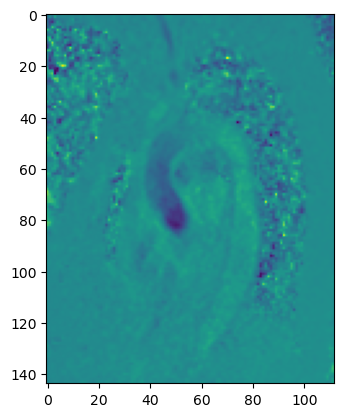

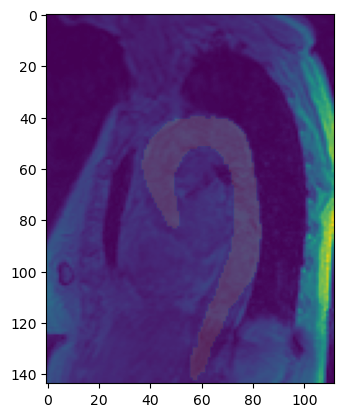

In [432]:
#slice_ = 0
%matplotlib inline
plt.imshow(images_tr[slice_, :,:, 3,1])
plt.show()
plt.imshow(images_tr[slice_, :,:, 3,0])
plt.imshow(labels_tr[slice_, :,:, 3], alpha= 0.1)
slice_ +=1 
plt.show()